# Sequence Models
## Day 2 of the summerschool

### Summary 

- We will train the models in pairs $(x,y)$ where $x$ and $y$ will be sequences.
- Once the model is trained, given an input sequence $x$ the model will predict
  a target sequence $y$.
  
In order to do so we will implement...
  
-  one inference algorithm for Hidden Markov Models.
    - We will use it to find the most likely hidden state sequence given an observation sequence. 
    


### Notation

#### Set of Words $\Sigma$ and set of states $\Lambda$
This notebook will use the following notation.

- $\Sigma := \{w_1,\ldots,w_J\}$ is the set of words (or vocabulary).
- $\Lambda:= \{c_1,\ldots, c_K\}$ is the set of labels.

A sentence is an element of the Kleene clousure of $\Sigma$, denoted by $\Sigma^*$.
The Kleene clousure of $\Sigma$, is defined as the set containing all possible sentences of arbitrary lengt that can be created using the words in $\Sigma$. More formally,

$$
\Sigma^* := \{\varepsilon\} \cup \Sigma \cup \Sigma^2 \cup \ldots
$$
where  $\{\varepsilon\}$ is an "empty word". In other words, inputs are observation sequences, $x = x_1 x_2 \ldots x_N$,  where each $x_i \in \Sigma$. 

Given such an $x$, we seek the corresponding state sequence, $y = y_1 y_2 \ldots y_N$, 
where each $y_i \in \Lambda$. We also consider two special states: the ${\tt start}$ symbol,
which starts the sequence, and the ${\tt stop}$ symbol, which ends the sequence. 



### Example 2.1
Consider a person who is only interested in four activities.
- walking in the park $({\tt walk})$,
- shopping (${\tt shop}$),
- cleaning the apartment (${\tt clean}$)
- playing tennis (${\tt tennis}$).

Also, consider that the choice of what the person does on a given day is determined exclusively by the weather on that day, which can be either ${\tt rainy}$ or ${\tt sunny}$. 

Now, supposing that we observe what the person did on a sequence of days, the question is: 
can we use that information to predict the weather on each of those days? 

To tackle this problem, we assume  that the weather behaves as a discrete Markov chain (with markov property 1): the weather on a given day depends only on the weather on the previous day. The entire system can be described as an HMM.

In this example 

$$
\begin{array}
\hline
\Sigma := \{ {\tt walk},{\tt shop},{\tt clean},{\tt tennis}\}\\
\Lambda: = \{ {\tt rainy},{\tt sunny} \} \\
\end{array}
$$


Let us assume that we are given access to three different sequences of days, containing both the activities performed by the person and the weather on those days.

The information given has the form $(x,y) = (x_i / y_i)$ where $x_i$ is a word in our vocabulary ( ${\tt walk},{\tt shop},{\tt clean},{\tt tennis}$) and $y_i$ is a state (${\tt rainy},{\tt sunny}$). The whole train set is:

- (${\tt walk/rainy, walk/sunny, shop/sunny, clean/sunny}$)
- (${\tt walk/rainy, walk/rainy, shop/rainy, clean/sunny}$)
- (${\tt walk/sunny, shop/sunny, shop/sunny, clean/sunny}$)

We will use this information  to train our model.

Now assume we are asked to predict the weather conditions on two different
sequences of days. During these two sequences, we observed the person performing the following activities: 

- $({\tt walk, walk, shop, clean})$
- $({\tt clean, walk, tennis, walk})$


The following image represents the first training sequence which starts with  ${\tt start}$ symbol, and ends with ${\tt stop}$.

<img src="./images_for_notebooks/hmm_new.pdf">


In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import sys
# We will this append to ensure we can import lxmls toolking
sys.path.append('../lxmls-toolkit')


In [20]:
import lxmls
import lxmls.readers.simple_sequence as ssr
import scipy
import numpy as np

## Exercise 2.1, Getting in touch with the provided classes

The objective of this exercises is to get in touch with the classes used to store the sequences, you will need this for the next exercise.

We will use

- class ``Sequence`` in ``lxmls/sequences/sequence.py`` file
- class ``LabelDictionary`` in ``lxmls/sequences/label_dictionary.py`` file
- class ``SequenceList`` in ``lxmls/sequences/sequence_list.py`` file

- class ``_SequenceIterator`` in ``lxmls/sequences/sequence_list.py`` file



In [21]:
# We could put the code of the classes here with no need to import anything from lxmls-toolkit
from lxmls.sequences.label_dictionary import LabelDictionary
from lxmls.sequences.sequence import Sequence
from lxmls.sequences.sequence_list import SequenceList

The following class will implement the train and test data from example 2.1


In [22]:
class SimpleSequence:

    def __init__(self):
        # Observation set.
        self.x_dict = LabelDictionary(['walk', 'shop', 'clean', 'tennis'])
        
        # State set.
        self.y_dict = LabelDictionary(['rainy', 'sunny'])
        
        # Generate training sequences.
        train_sequences = SequenceList(self.x_dict, self.y_dict)
        train_sequences.add_sequence(['walk', 'walk', 'shop', 'clean'], ['rainy', 'sunny', 'sunny', 'sunny'])
        train_sequences.add_sequence(['walk', 'walk', 'shop', 'clean'], ['rainy', 'rainy', 'rainy', 'sunny'])
        train_sequences.add_sequence(['walk', 'shop', 'shop', 'clean'], ['sunny', 'sunny', 'sunny', 'sunny'])

        # Generate test sequences.
        test_sequences = SequenceList(self.x_dict, self.y_dict)
        test_sequences.add_sequence(['walk', 'walk', 'shop', 'clean'], ['rainy', 'sunny', 'sunny', 'sunny'])
        test_sequences.add_sequence(['clean', 'walk', 'tennis', 'walk'], ['sunny', 'sunny', 'sunny', 'sunny'])

        self.train = train_sequences
        self.test = test_sequences

Notice that x_dict and y_dict are ``LabelDictionary``

**``LabelDictionary`` objects are instanciated with a list of strings **

Notice that the data in ``train_sequences`` and ``test_sequences`` are instanciated as ``SequenceList`` objects. 

**``SequenceList`` objects are instanciated with**

- ``x_dict``  containing all possible words $\Sigma$
- ``y_dict``  containing all possible states $\Lambda$
- ``seq_list`` list containing the data (if nothing is passed it starts with an empty list)


**``SequenceList`` objects have a method ``add_sequence`` which recieves as input two lists of strings**
- ``SequenceList.add_sequence`` appends the given sequence with labels $x,y$ as a ``Sequence`` object.

**``Sequence`` objects are instanciated with **:

- `` x`` list of observations
- `` y`` list of states
- `` nr`` length of x and y
- ``sequence_list`` 
      
 

 Now we will load the data from Example 2.1 and look at the training and test set.

In [23]:
simple = ssr.SimpleSequence()
for sequence in simple.train.seq_list: 
    print sequence

walk/rainy walk/sunny shop/sunny clean/sunny 
walk/rainy walk/rainy shop/rainy clean/sunny 
walk/sunny shop/sunny shop/sunny clean/sunny 


In [24]:
for sequence in simple.test.seq_list: 
    print sequence

walk/rainy walk/sunny shop/sunny clean/sunny 
clean/sunny walk/sunny tennis/sunny walk/sunny 


In [25]:
type(simple.train.seq_list[0])

lxmls.sequences.sequence.Sequence

In [26]:
simple.train.seq_list[0].__dict__

{'nr': 0,
 'sequence_list': [walk/rainy walk/sunny shop/sunny clean/sunny , walk/rainy walk/rainy shop/rainy clean/sunny , walk/sunny shop/sunny shop/sunny clean/sunny ],
 'x': [0, 0, 1, 2],
 'y': [0, 1, 1, 1]}

In [27]:
type(simple.train.seq_list[0].sequence_list)

lxmls.sequences.sequence_list.SequenceList

In [28]:
for sequence in simple.train.seq_list:
    print sequence.x

[0, 0, 1, 2]
[0, 0, 1, 2]
[0, 1, 1, 2]


# HMM Model details


The probability distributions

- $P(Y_{i}|Y_{i-1})$ are called transition probabilities; 
- $P(Y_{1}|Y_{0} = {\tt start})$ are the initial probabilities
- $P(Y_{N+1}={\tt stop} |Y_{N})$ the final probabilities

A first order HMM model has the following independence assumptions over the joint distribution $P(X=x,Y=y)$:

- $\textbf{Independence of previous states.}$: The probability of
    being in a given state at position $i$ only depends on
    the state of the previous position $i-1$. Formally:
    
    \begin{equation*}
    P (Y_i = y_i | Y_{i-1} = y_{i-1}, Y_{i-2} = y_{i-2}, \ldots, Y_1 = y_1) = P (Y_i = y_i | Y_{i-1} = y_{i-1})
    \end{equation*} 
    
    defining a first order Markov chain


- $\textbf{Homogeneous transition.}$: The probability of
    making a transition from state $c_l$ to state $c_k$ is independent of
    the particular position in the sequence. That is, for all $i,t \in \{1,\ldots,N\}$,
    
     \begin{equation*}
    P (Y_i = c_k | Y_{i-1} = c_l) =  P (Y_{t} = c_k | Y_{t-1} = c_l)
     \end{equation*}


- $\textbf{Observation independence.}$  The probability of
    observing $X_i = x_i$ at position $i$ is fully determined by the state $Y_i$
    at that position. Formally, 
    
     \begin{equation*}
     P (X_i = x_i | Y_1=y_1, \ldots, Y_i=y_i, \ldots, Y_N=y_N) = P(X_i = x_i | Y_i = y_i)
      \end{equation*}
     
     This probability is independent of the
    particular position so, for every $i$ and $t$, we can write:  
    
     \begin{equation*}
    P(X_i = w_j | Y_i = c_k) = P(X_{t} = w_j | Y_{t} = c_k)
     \end{equation*}

These conditional independence assumptions are crucial to allow
efficient inference, as it will be described.


### Table summary

 The distributions that define the HMM model are summarized in the following table

<img src="./images_for_notebooks/Hmm_table.png" style="max-width:100%; width: 75%">

### Joint distribution $P(X,Y)$

The joint probability of a first order HMM can be written as follows:
$$
P(X_1=x_1,\ldots,X_N=x_N,Y_1=y_1,\ldots,Y_N=y_N)= 
P_{\mathrm{init}}(y_1|\text{ start}) 
\cdot
\left(
\prod_{i=1}^{N-1} P_{\mathrm{trans}}(y_{i+1}|y_i)
\right)
\times
P_{\mathrm{final}}(\text{ stop}|y_N)
\cdot 
\prod_{i=1}^{N} P_{\mathrm{emiss}}(x_i|y_i)
$$

#### Example: computing the probability of a pair $(x,y)$
the probability of an HMM for the first training instance of Example 2.1, which is 

$$
(x,y) = ([\text{walk}, \text{walk}, \text{shop}, \text{clean}],  [\text{rainy}, \text{sunny},\text{ sunny}, \text{sunny}])
$$
can be computed as

$$
P(X_1=x_1,\ldots,X_4=x_4,Y_1=y_1,\ldots,Y_4=y_4)= 
P_{\text{init}}(\text{rainy}|\text{ start}) 
\cdot
P_{\mathrm{trans}}(\text{ sunny}|\text{ rainy}) 
\cdot
P_{\mathrm{trans}}(\text{ sunny}|\text{ sunny}) 
\cdot
P_{\mathrm{trans}}(\text{ sunny}|\text{ sunny}) 
\cdot
P_{\mathrm{final}}(\text{ stop}|\text{ sunny}) 
\cdot
P_{\mathrm{emiss}}(\text{ walk}|\text{ rainy}) 
\cdot
P_{\mathrm{emiss}}(\text{ walk}|\text{ sunny}) 
\cdot
P_{\mathrm{emiss}}(\text{ shop}|\text{ sunny})
\cdot
P_{\mathrm{emiss}}(\text{ clean}|\text{ sunny}).
$$

# HMM Maximum Likelihood Training

We have seen how to compute the probability of a pair $(x,y)$ given the probabilities $P_{\text{init}}, P_{\text{trans}},P_{\text{final}},P_{\text{emiss}}$.

Now we will study how to find the parameters that define $P_{\text{init}}, P_{\text{trans}},P_{\text{final}},P_{\text{emiss}}$. We will refer to the set of parameters as $\theta$.

Given a dataset $\mathcal{D}_L$, we will try to find the parameters $\theta$ that maximize the log likelihood function:

$$
\log \prod_{m=1}^M P_{\theta} (X=x^m,Y=y^m) =  \sum_{m=1}^M  \log P_{\theta} (X=x^m,Y=y^m)
$$

where the joint distribution $P_{\theta} (X=x^m,Y=y^m)$ is given by the formula 

$$
P(X_1=x_1,\ldots,X_N=x_N,Y_1=y_1,\ldots,Y_N=y_N)= 
P_{\mathrm{init}}(y_1|\text{ start}) 
\cdot
\left(
\prod_{i=1}^{N-1} P_{\mathrm{trans}}(y_{i+1}|y_i)
\right)
\times
P_{\mathrm{final}}(\text{ stop}|y_N)
\cdot 
\prod_{i=1}^{N} P_{\mathrm{emiss}}(x_i|y_i)
$$

In some applications  (such as speech recognition) 
the observation variables are continuous, hence the emission distributions are real-valued ( e.g. mixtures of Gaussians). In our case, both the state set and the observation set are discrete (and finite), therefore we use
multinomial distributions for the emission and 
transition probabilities. 

Multinomial distributions are attractive for several reasons: first of
all, they are easy to implement; secondly, the maximum likelihood estimation of the parameters has a simple closed form. The parameters are just normalized counts of events that occur in the corpus.

 Let us define the following
quantities, called sufficient statistics, that represent the counts of
each event in the corpus:


- Initial counts:
$$C_{\text{init}}(c_k) = \sum_{m=1}^M
\mathbb{1} (y^m_1 = c_k)
$$

- Transition counts: $$
C_{\text{trans}}(c_k,c_l) =
\sum_{m=1}^M  \sum_{i = 2}^{N}
\mathbb{1} (y^m_i = c_k \wedge y^m_{i-1} = c_l)
$$

- Final counts:
$$
C_{\text{final}}(c_k) = \sum_{m=1}^M
\mathbb{1} (y^m_N = c_k)
$$

- Emission counts:
$$
C_{\text{emiss}}(w_j,c_k) = \sum_{m=1}^M
\sum_{i = 1}^{N}
\mathbb{1} (x^m_i = w_j \wedge y^m_i = c_k)
$$

Here $y^m_i$,  the underscript denotes the state index position for a given sequence, and the superscript denotes the sequence index in the dataset, and the same applies for the observations.
Note that $\mathbb{1}$ is an indicator function that has the value 1 when the
particular event happens, and zero otherwise. In other words, the previous
equations go through the training corpus and count how
often each event occurs. For example trainsition counts, counts how many times $c_k$ follows state $c_l$. Therefore, $C_{\text{trans}}(\text{ sunny},\text{ rainy})$ contains the number of times that a sunny day followed a rainy day.


#### Sanity check for the HMM


- Initial counts must sum to the number of sentences  $$ \sum_{k=1}^K C_{\text{init}}(c_k) = M$$

- Transition counts and Final Counts should sum to the number of tokens: $$\sum_{k,l=1}^K C_{\text{trans}}(c_k,c_l)  + \sum_{k=1}^K C_{\text{final}}(c_k) = M \cdot N$$

- Emission counts must sum to the number of tokens
$$
\sum_{j=1}^J \sum_{k=1}^K C_{\text{emiss}}(w_j,c_k) = M \cdot N 
$$

## Training an HMM: Finding the parameters of the distributions 

The following formulas specify how to find the parameters of the HMM:

$$
P_{\text{init}}(c_k \,\vert\, \text{start}) = \frac{C_{\text{init}}(c_k)}{ \sum_{k=1}^K
C_{\text{init}} (c_l)}
$$

$$
P_{\text{final}}(\text{stop} \,\vert\, c_l) = \frac{C_{\text{final}}(c_l) }
{\sum_{k=1}^K C_{\text{trans}}(c_k,c_l) + C_{\text{final}}(c_l)}
$$

$$
P_{\text{trans}}( c_k \,\vert\, c_l) = \frac{C_{\text{trans}}(c_k, c_l) }
{\sum_{p=1}^K C_{\text{trans}}(c_p,c_l) + C_{\text{final}}(c_l)}
$$

$$
P_{\text{emiss}} (w_j \,\vert\, c_k) = \frac{C_{\text{emiss}} (w_j, c_k) }{\sum_{q=1}^J C_{\text{emiss}}(w_q,c_k)}
$$


## Exercise 2.2 

 The provided function train supervised from the hmm.py file implements the above parameter estimates.  Run this function given the simple dataset above and look at the estimated probabilities. Are they correct? 

You can also check the variables ending in  counts instead of  probs to see the raw counts (for example, typing ``hmm.initial_counts`` will show you the raw counts of initial states). How are the counts related to the probabilities?

In [12]:
import lxmls.sequences.hmm as hmmc
import lxmls.readers.simple_sequence as ssr

# Load data
simple = ssr.SimpleSequence()

# instanciate HMM model using the loaded data
hmm = hmmc.HMM(simple.x_dict, simple.y_dict)

# Train the HMM
hmm.train_supervised(simple.train)

In [13]:
print "Initial Counts:\n", hmm.initial_counts ,"\n"
print "Transition Counts:\n", hmm.transition_counts ,"\n"
print "Final Counts:\n", hmm.final_counts ,"\n"
print "Emission Counts\n", hmm.emission_counts

Initial Counts:
[ 2.  1.] 

Transition Counts:
[[ 2.  0.]
 [ 2.  5.]] 

Final Counts:
[ 0.  3.] 

Emission Counts
[[ 3.  2.]
 [ 1.  3.]
 [ 0.  3.]
 [ 0.  0.]]


In [14]:
print "initial_probs "
print hmm.initial_counts / np.sum(hmm.initial_counts)

print "\ntransition_probs"
print hmm.transition_counts / (np.sum(hmm.transition_counts, 0) + hmm.final_counts)

print "\nfinal_probs"
print hmm.final_counts / (np.sum(hmm.transition_counts, 0) + hmm.final_counts)

print "\nemission_probs"
print hmm.emission_counts / np.sum(hmm.emission_counts, 0)

initial_probs 
[ 0.66666667  0.33333333]

transition_probs
[[ 0.5    0.   ]
 [ 0.5    0.625]]

final_probs
[ 0.     0.375]

emission_probs
[[ 0.75   0.25 ]
 [ 0.25   0.375]
 [ 0.     0.375]
 [ 0.     0.   ]]


OBSERVATION:

**If we stack trainsition and final counts and normalize them we get
a proper conditional probability distribution**

In [15]:
transitions_with_final_counts = np.vstack((hmm.transition_counts,
                                           hmm.final_counts))

In [16]:
transitions_with_final_counts 

array([[ 2.,  0.],
       [ 2.,  5.],
       [ 0.,  3.]])

In [17]:
transitions_with_final_counts/ np.sum(transitions_with_final_counts,0)

array([[ 0.5  ,  0.   ],
       [ 0.5  ,  0.625],
       [ 0.   ,  0.375]])

In [26]:
print "Initial Probabilities:\n", hmm.initial_probs ,"\n"
print "Transition 'Probabilities':\n", hmm.transition_probs ,"\n"
print "Final 'Probabilities':\n", hmm.final_probs ,"\n"
print "Emission Probabilities\n", hmm.emission_probs

Initial Probabilities:
[ 0.66666667  0.33333333] 

Transition 'Probabilities':
[[ 0.5    0.   ]
 [ 0.5    0.625]] 

Final 'Probabilities':
[ 0.     0.375] 

Emission Probabilities
[[ 0.75   0.25 ]
 [ 0.25   0.375]
 [ 0.     0.375]
 [ 0.     0.   ]]


# Decoding a Sequence

**So far we have seen how to train a HMM.**

**Now we will focus on, once trained, how to make predictions efficiently with a HMM**


Given the learned parameters and a new
observation sequence $x = x_1\ldots x_N$, we want to find the sequence of hidden states $y^* = y_1^* \ldots y_N^*$ that "best" explains it.
 This is called the **decoding problem**. 
 
 There are several ways to define what we mean by the "best" $y^*$, depending on our goal: for instance, we may want to minimize the probability of error on each hidden
variable $Y_i$ (posterior decoding), or we may want to find the best assignment to the sequence $Y_1\ldots Y_N$ as a whole (viterbi decoding). 
Therefore, finding the best sequence
can be accomplished through different approaches:

- ** posterior decoding** or **minimum risk decoding**

    This approach selects, at each step $i$, the state that maximizes the conditional probability of $Y_i$ given all the visible sequence. Notice that the state sequence that this approach reaches is not necesary the one that maximizes the probability of the whole sequence and state sequence.
    
\begin{equation}
y_i^* = \arg \max_{y_i \in \Lambda} P(Y_i=y_i | X_1=x_1,\ldots,X_N =x_N).
\end{equation}

- ** Viterbi decoding**

    This approach choose the sequence of states that, overall, has the highest probability.

\begin{eqnarray}
y^* &=& \text{argmax}_{y = y_1\ldots y_N} P(Y_1=y_1,\ldots, Y_N=y_N | X_1=x_1,\ldots,X_N =x_N)\nonumber\\
&=& \text{argmax}_{y = y_1\ldots y_N} P(Y_1=y_1,\ldots, Y_N=y_N, X_1=x_1,\ldots,X_N =x_N).
\end{eqnarray}

### Unfolding all state sequences: trellis representation
Both previous approaches, viterbi decoding and posterior decoding, rely on dynamic programming and make use of the
independence assumptions of the HMM model. Moreover, they use an alternative representation of the HMM called a trellis. 

A trellis unfolds all possible states for each position and it makes explicit the independence assumption: each position only
depends on the previous position. Here, each column represents a position in the sequence and each row represents a possible state. The following figure shows the trellis for $x = \text{walk walk shop clean}$


<img src="./images_for_notebooks/hmm_trellis.png" style="max-width:100%; width: 60%">



Considering the trellis representation, note that we can include the following information:
- an initial probability to the arrows that depart from the start symbol;
- a final probability} to the arrows that reach the stop symbol
- a transition probability to the remaining arrows
-  an emission probability to each circle, which is the probability that the observed symbol is emitted by that particular state.


###  Posterior decoding

picking the highest state posterior for each position $i$ in the sequence:

\begin{equation}
y_i^* = \arg \max_{y_i \in \Lambda} P(Y_i=y_i | X_1=x_1,\ldots,X_N =x_N).
\end{equation}
 
Note, however, that this approach does not guarantee that the sequence $y^*=y_1^* \ldots y_N^*$ will be a
valid sequence of the model. For instance, there might be a transition
between two of the best state posteriors with probability zero. 

### Viterbi decoding

consists in
picking the best global hidden state sequence: 

\begin{eqnarray}
y^* &=& \text{argmax}_{y = y_1\ldots y_N} P(Y_1=y_1,\ldots, Y_N=y_N | X_1=x_1,\ldots,X_N =x_N)\nonumber\\
&=& \text{argmax}_{y = y_1\ldots y_N} P(Y_1=y_1,\ldots, Y_N=y_N, X_1=x_1,\ldots,X_N =x_N).
\end{eqnarray}


## Viterbi decoding

### Working with scores not probabilities

For convenience, we will be working with 
log-probabilities, rather than probabilities. Therefore, if we associate to each circle and arrow in the trellis a score that corresponds
to the log-probabilities above, and if we define the score of a path
connecting the ${\tt start}$ and  ${\tt stop}$ symbols as
the sum of the scores of the circles and arrows it traverses, 
then the goal of **finding the most likely sequence of states (Viterbi decoding) corresponds to finding the path with the highest score**.



The trellis scores are given by the following expressions:

- For each state $c_k$:

\begin{eqnarray}
\mathrm{score}_{\mathrm{init}}(c_k) &=&
\log P_{\mathrm{init}}(Y_{1} = c_k | \text{start}).
\end{eqnarray}


- For each position $i \in {1,\ldots,N-1}$ and each pair of states $c_k$ and $c_l$:

\begin{eqnarray}
\mathrm{score}_{\mathrm{trans}}(i, c_k, c_l) &=&
\log P_{\mathrm{trans}}(Y_{i+1} = c_k | Y_i = c_l).
\end{eqnarray}


- For each state $c_l$:

\begin{eqnarray}
\mathrm{score}_{\mathrm{final}}(c_l) &=&
\log P_{\mathrm{final}}(\text{stop} | Y_N = c_l).
\end{eqnarray}


- For each position $i \in {1,\ldots,N}$ and state $c_k$:

\begin{eqnarray}
\mathrm{score}_{\mathrm{emiss}}(i, c_k) &=&
\log P_{\mathrm{emiss}}(X_i = x_i | Y_i = c_k).
\end{eqnarray}



#### The score of a path in the trellis is equivalent to the log-probability log P(x, y)

Since the joint distribution $P_{\theta} (X=x^m,Y=y^m)$ is given by the formula 

$$
P(x,y)= 
P_{\mathrm{init}}(y_1|\text{start}) 
\left(
\prod_{i=1}^{N-1} P_{\mathrm{trans}}(y_{i+1}|y_i)
\right)
P_{\mathrm{final}}(\text{stop}|y_N)
\prod_{i=1}^{N} P_{\mathrm{emiss}}(x_i|y_i)
$$

when we apply the logarithm we get a sum of logarithms of 4 terms. Using the score notation defined above we get


$$
\log P(x,y)= \mathrm{score}_{\mathrm{init}}(y_1) + \sum_{i=1}^{N-1}\mathrm{score}_{\mathrm{trans}}(i, y_i, y_{i-1}) +
\mathrm{score}_{\mathrm{final}}(c_l) +
 \sum_{i=1}^{N} \mathrm{score}_{\mathrm{emiss}}(i, y_k) 
$$

Since a path in the trellis is just an assignment of states $y=y_1,\dots,y_N$ given words $x=x_1,\dots,x_N$, computing the score of a path is just the sum of scores above. Moreover we have seen this is equivalent to computing the log probability of $(x,y)$.

##  Exercise 2.3

Convince yourself that the score of a path in the trellis (summing over the scores above) is equivalent to the log-probability 
log P(X = x, Y = y), as defined in Eq. 2.2. Use the given function compute scores on the first training sequence and confirm
that the values are correct.
You should get the same values as presented below.

** Suggestion: use an example of length 5 instead of 4, emission_scores is a matrix of n_rows=len(sequence)**


In [29]:
import lxmls.sequences.hmm as hmmc
import lxmls.readers.simple_sequence as ssr
simple = ssr.SimpleSequence()

hmm = hmmc.HMM(simple.x_dict, simple.y_dict)
hmm.train_supervised(simple.train)

In [30]:
initial_scores, transition_scores, final_scores, emission_scores = hmm.compute_scores(simple.train.seq_list[1])

print "initial_scores;\n", initial_scores, "\n"
print "transition_scores: \n",transition_scores, "\n"
print "final_scores:\n", final_scores, "\n"
print "emission_scores:\n", emission_scores, "\n"

initial_scores;
[-0.40546511 -1.09861229] 

transition_scores: 
[[[-0.69314718        -inf]
  [-0.69314718 -0.47000363]]

 [[-0.69314718        -inf]
  [-0.69314718 -0.47000363]]

 [[-0.69314718        -inf]
  [-0.69314718 -0.47000363]]] 

final_scores:
[       -inf -0.98082925] 

emission_scores:
[[-0.28768207 -1.38629436]
 [-0.28768207 -1.38629436]
 [-1.38629436 -0.98082925]
 [       -inf -0.98082925]] 



../lxmls-toolkit/lxmls/sequences/hmm.py:173: RuntimeWarning: divide by zero encountered in log
  transition_scores[pos-1,:,:] = np.log(self.transition_probs)
../lxmls-toolkit/lxmls/sequences/hmm.py:171: RuntimeWarning: divide by zero encountered in log
  emission_scores[pos,:] = np.log(self.emission_probs[sequence.x[pos], :])
../lxmls-toolkit/lxmls/sequences/hmm.py:176: RuntimeWarning: divide by zero encountered in log
  final_scores = np.log(self.final_probs)


### Notice a couple of things:

- transition_scores is a matrix of shape (3,2,2), the first dimension corresponds to the len(x)-1
    - The same matrix at each position is copied since the HMM is homogeneous 

In [31]:
simple.train.seq_list[1]

walk/rainy walk/rainy shop/rainy clean/sunny 

In [32]:
print "Emission Probabilities\n", hmm.emission_probs

Emission Probabilities
[[ 0.75   0.25 ]
 [ 0.25   0.375]
 [ 0.     0.375]
 [ 0.     0.   ]]


In [33]:
print "transition Probabilities\n", hmm.transition_probs

transition Probabilities
[[ 0.5    0.   ]
 [ 0.5    0.625]]


In [34]:
transition_scores.shape

(3, 2, 2)

- **if emission_scores = log (emission_probabilities) why are there not 3 -inf????**
- **Why we save length(x)-1 times the transition_scores??**


    def compute_scores(self, sequence):
        length = len(sequence.x) # Length of the sequence.
        num_states = self.get_num_states() # Number of states of the HMM.

        # Initial position.
        initial_scores = np.log(self.initial_probs)

        # Intermediate position.
        # logzero is just -np.inf
        emission_scores = np.zeros([length, num_states]) + logzero()
        transition_scores = np.zeros([length-1, num_states, num_states]) + logzero()
        for pos in xrange(length):
            import pdb;pdb.set_trace()
            emission_scores[pos,:] = np.log(self.emission_probs[sequence.x[pos], :])
            if pos > 0:
                transition_scores[pos-1,:,:] = np.log(self.transition_probs)

        # Final position.
        final_scores = np.log(self.final_probs)

        return initial_scores, transition_scores, final_scores, emission_scores
        
        
Could be changed to


    def compute_scores(self, sequence):
        length = len(sequence.x) # Length of the sequence.
        num_states = self.get_num_states() # Number of states of the HMM.

        # Initial position.
        initial_scores = np.log(self.initial_probs)

        # Intermediate positions
        transition_scores = np.log(self.transition_probs) ## now we don't copy the matrix per position
        emission_scores = np.log(self.emission_probs[sequence.x,:])
        
        # Final position.
        final_scores = np.log(self.final_probs)

        return initial_scores, transition_scores, final_scores, emission_scores
        

## Computations in log-domain

We will see that the decoding algorithms 
will need to multiply twice as many probability terms as 
the length $N$ of the sequence. 
This may cause underflowing problems 
when $N$ is large, since the nested multiplication of numbers smaller than 1 may easily become smaller than the machine precision. To avoid that
problem,  presents a scaled version of the decoding algorithms that avoids this problem. An alternative, which is widely used, is computing
in the log-domain. That is, instead of 
manipulating probabilities, manipulate log-probabilities (the scores presented above). 

Every time we need to multiply probabilities, 
we can sum their log-representations, since:

\begin{equation}
\log(\exp(a) \times \exp(b)) = a+b.
\end{equation}

Sometimes, we need to add probabilities. 
In the log domain, this requires us to compute 

\begin{equation}
\log(\exp(a) + \exp(b)) = a + \log(1 + \exp(b-a)),
\end{equation}

where we assume that $a$ is smaller than $b$.

## Exercise 2.4 

Look at the module ``sequences/log_domain.py.`` This module implements a function ```logsum_pair(logx, logy)``` to add two numbers
represented in the log-domain; it returns their sum also represented in the log-domain.

The function ```logsum(logv)``` sums all components of an array represented in the log-domain.
This will be used later in our decoding algorithms. To observe why this is important, type the following:

In [36]:
import numpy as np
a = np.random.rand(10)
print np.log(sum(np.exp(a)))
print np.log(sum(np.exp(10*a)))
print np.log(sum(np.exp(100*a)))
print np.log(sum(np.exp(1000*a)))

print "\n"
from lxmls.sequences.log_domain import logsum
print logsum(a)
print logsum(10*a)
print logsum(100*a)
print logsum(1000*a)

3.06353529448
10.8981388801
96.7512830351
inf


3.06353529448
10.8981388801
96.7512830351
966.386645529


/Users/macpro/anaconda/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in exp


# Posterior decoding

Posterior decoding consists
in picking state with the highest posterior for each position in the sequence independently; for 
each $i = 1,\ldots,N$:

\begin{equation}
y_i^* = \text{argmax}_{y_i \in \Lambda} P(Y_i=y_i | X = x).
\end{equation}

The **sequence posterior distribution** is the probability of a particular
hidden state sequence given that we have observed a particular
sequence. Moreover, we will be interested in two other posteriors distributions:
the **state posterior distribution**, corresponding to the
probability of being in a given state in a certain position given the
observed sequence; and the \textbf{transition posterior distribution},
which is the probability of making a particular transition, from position $i$ to
$i+1$, given the observed sequence. 

They are formally defined as follows:

- Sequence  Posterior
$$P(Y=y|X=x) = \frac{P(X=x,Y=y)}{P(X=x)}
$$

- State Posterior
$$
P(Y_i=y_i | X=x)
$$

- Transition Posterior
$$
P(Y_{i+1}=y_{i+1},Y_i=y_i| X=x)
$$


### Computing posteriors involves beeing able to compute $P(X=x)$
To compute the posteriors, a first step is to be able to compute the 
likelihood of
the sequence $P(X=x)$, which corresponds to summing the probability of all
possible hidden state sequences.

\begin{equation}
\mathbf{Likelihood\!:}\;\;\;\; P(X=x) = \displaystyle \sum_{y \in \Lambda^N} P(X=x,Y=y).
\end{equation}

The number of possible hidden state sequences is exponential in the
length of the sequence ($|\Lambda|^N$),
 which makes the sum over all of them hard. 
 In our simple
 example, there are $2^4 = 16$ paths, which we can actually explicitly enumerate
 and calculate their probability using Equation of the joint probability $P(x,y)$. But this is as far as it goes: for example, for Part-of-Speech
 tagging with a small tagset of 12 tags and a medium size
 sentence of length 10, there are $12^{10} = 61 917 364 224$ such
 paths. 
 
 Yet, we must be able to compute this sum (sum over $y \in \Lambda^N$) to compute the above likelihood
formula; this is called the inference problem. For sequence models, there is a well known dynamic programming algorithm,
the **Forward-Backward** (FB) algorithm, which allows the computation
to be performed in linear time, The runtime is linear with respect
to the sequence length. More precisely, 
the runtime is $O(N|\Lambda|^2)$. 
A naive enumeration would cost $O(|\Lambda|^N)$.

The FB algorithm relies on the independence of previous states
assumption, which  
is illustrated in the trellis view by having arrows only between consecutive states. 
The FB algorithm defines two auxiliary probabilities, the forward probability and the backward probability. 



## Efficient forward probability computation

The forward probability represents the probability that in position
$i$ we are in state $Y_i = c_k$ and that we have observed $x_1,\ldots,x_i$
up to that position. Therefore, its mathematical expression is:
\begin{equation}
\mathbf{Forward \ Probability\!:}\;\;\;\;  \mathrm{forward}(i, c_k) = P(Y_i = c_k, X_1=x_1,\ldots, X_i = x_i)
\end{equation}


Using the independence assumptions of the HMM we can compute $\mathrm{forward}(i, c_k)$ using all the forward computations \{$\mathrm{forward}(i -1, c)$ for $c \in \Lambda$\}. In order to facilitate the notation of the following argument we will denote by $x_{i:j}$  the assignemnt $X_i = x_i, \dots, X_j = x_j$. Therefore we can write   $\mathrm{forward}(i, y_i) $ as $P( y_i, x_{1:i } ) $ and rewrite the forward expression as follows:

\begin{equation}
  P( y_i, x_{1:i } ) =  \sum_{y_{i-1} \in \Lambda} P( y_i ,y_{i-1}, x_{1:i } )  =  \sum_{y_{i-1} \in \Lambda} P( x_i  | y_i,  y_{i-1},  x_{1:i-1 } ) \cdot P(y_i  | y_{i-1},  x_{1:i-1 }) \cdot P(y_{i-1},  x_{1:i-1 })  
\end{equation}


Using the **Observation independence** and the **Independence of previous states** properties of the first order HMM we have $P( x_i  | y_i,  y_{i-1},  x_{1:i-1 } ) = P( x_i  | y_i) $ and $P(y_i  | y_{i-1},  x_{1:i-1 })  = P(y_i  | y_{i-1})  $. Therefore the previous equation can be written, 
for $i \in \{2,\dots,N\}$ (where $N$ is the length of the sequence), as 

\begin{equation}
 \mathrm{forward}(i, y_i)  = \sum_{y_{i-1} \in \Lambda} P( x_i  | y_i, ) \cdot P(y_i  | y_{i-1}) \cdot \mathrm{forward}(i-1, y_{i-1})   
\end{equation}


The previous equation proves that  the forward probability can be defined by the
following recurrence rule: 

\begin{eqnarray}
\mathrm{forward}(1, c_k)&=& P_{\text{init}}(c_k|\text{start}) \times P_{\mathrm{emiss}}(x_1 | c_k)
 \\
 \mathrm{forward}(i, c_k) &=& \left(  \sum_{c_l \in \Lambda} P_{\mathrm{trans}}(c_k | c_l) \times \mathrm{forward}(i-1, c_l) \right) \times P_{\mathrm{emiss}}(x_i | c_k) 
 \\
  \mathrm{forward}(N+1, \text{stop}) &=& \sum_{c_l \in \Lambda} P_{\text{final}}(\text{ stop} | c_l) \times \mathrm{forward}(N, c_l).
\end{eqnarray}


Using the forward trellis one can compute the likelihood simply as:

\begin{equation}
P(X=x) = \mathrm{forward}(N+1, \text{ stop}).
\end{equation}

Although the forward probability is enough to calculate the likelihood of a given sequence, we will also need the backward probability to calculate the state posteriors. 




## Efficient backward probability computation



The backward probability is similar to the forward probability, but operates in the inverse direction.
It represents the probability of observing $x_{i+1},\ldots,x_N$ from position $i+1$ up to $N$, given that at position $i$ we are at state $Y_i = c_l$:

\begin{equation}
\mathbf{Backward \ Probability\!:}\;\;\;\;  \text{backward}(i, c_l) = P(X_{i+1}=x_{i+1},\ldots, X_N=x_N | Y_i = c_l).
\end{equation}



Using the independence assumptions of the HMM we can compute $\text{backward}(i, c_k)$ using all the backward computations $\text{backward}(i +1, c)$ for $c \in \Lambda$.

Therefore we can write   $\text{backward}(i, y_i) $ as $P( x_{i+1:N} | y_i ) $ and rewrite the forward expression as follows:

\begin{equation}
  P( x_{i+1:N} | y_i ) =  \sum_{y_{i+1} \in \Lambda} P( x_{i+1:N}, y_{i+1} | y_i)  =  \sum_{y_{i+1} \in \Lambda} P( x_{i+2:N} | y_i, y_{i+1}, x_{i+1}) 
   P( x_{i+1}, |  y_{i+1},  y_{i}) P( y_{i+1} | y_i)
\end{equation}

Using the previous equation we have proved that the backward probability can be defined by the following recurrence rule:


\begin{eqnarray}
\mathrm{backward}(N, c_l) &=& P_{\text{final}}(\text{stop} | c_l)  \\
\text{backward}(i, c_l) &=&  \displaystyle \sum_{c_k \in \Lambda} P_{\text{trans}}(c_k | c_l) \times 
\text{backward}(i+1, c_k) \times P_{\text{emiss}}(x_{i+1} | c_k) 
 \\
  \mathrm{backward}(0, \text{start}) &=& \sum_{c_k \in \Lambda} P_{\mathrm{init}}(c_k | \text{ start}) \times \mathrm{backward}(1, c_k) \times P_{\mathrm{emiss}}(x_{1} | c_k).
 \end{eqnarray}

Using the backward trellis one can compute the likelihood simply as:

\begin{equation}
P(X=x) = \mathrm{backward}(0, \text{start}).
\end{equation}



## The forward backward algorithm

We have seen how we can compute the probability of a sequence $x$ using the the forward and backward probabilities by computing  $\mathrm{forward}(N+1, \text{ stop})$ and $ \mathrm{backward}(0, \text{ start})$ respectively. Moreover,  the probability of a sequence $x$ can be computed with both forward and backward probabilities at a particular position $i$. 

The probability of a  given sequence $x$ at any position $i$ in the sequence can be computed
as follows:


\begin{eqnarray}
  P(X=x) &=& 
  \sum_{c_k \in \Lambda} P(X_1=x_1,\ldots, X_N=x_N,Y_i=c_k)\nonumber\\
  & =&
  \sum_{c_k \in \Lambda} 
  \underbrace{P(X_1=x_1,\ldots, X_i=x_i, Y_i=c_k)}_{\mathrm{forward}(i,c_k)} \times 
  \underbrace{P(X_{i+1}=x_{i+1},\ldots, X_N=x_N| Y_i=c_k)}_{\mathrm{backward}(i,c_k)}\nonumber\\
  &=& \sum_{c_k \in \Lambda} \mathrm{forward}(i,c_k) \times \mathrm{backward}(i,c_k).
\end{eqnarray}



This equation will work for any choice of $i$. Although redundant, this fact is useful when implementing an
HMM as a sanity check that the computations are being performed
correctly, since one can compute this expression for several $i$; they should all yield the same value. 

The following pseudocode shows the the forward backward algorithm. 

<img src="./images_for_notebooks/fb_alg.png"  style="max-width:100%; width: 50%">

The reader can notice that the $forward$ and $backward$ computations in the algorithm make use of $P_{emiss}$ and $P_{trans}$. There are a couple of details that should be taken into account if the reader wants to understand the algorithm using scores instead of probabilities.


- $forward(i,\hat{c})$  is computed using $P_{emiss}(x_i | \hat{c})$ which does not depend on the sum over all possible states $c_k \in  \Lambda $. Therefore when taking the logarithm of the sum over all possible states the recurrence of the forward computations can be split as a sum of two logarithms.


- $backward(i,\hat{c})$  is computed using $ P_{\text{trans}}(c_k | \hat{c} )$ and $P_{\text{emiss}}(x_{i+1} | c_k) $ both of  which  depend on $c_k$. Therefore when taking the logarithm of the sum the expression cannot be split as a sum of logarithms.



Given the forward and backward probabilities, one can compute both the state
and transition posteriors as follows:


\begin{align}
 \mathbf{State \ Posterior\!:}\;\;\;\;  & P(Y_i = y_i| X=x) = \frac{\mathrm{forward}(i, y_i) \times 
 \mathrm{backward}(i, y_i)}{P(X=x)}\\
 \mathbf{Transition \ Posterior\!:}\;\;\;\; &
 P(Y_i = y_i, Y_{i+1} = y_{i+1} | X=x)= \nonumber\\
 &
   \frac{\mathrm{forward}(i, y_i) \times 
   P_{\mathrm{trans}}(y_{i+1}|y_i) \times
   P_{\mathrm{emiss}}(x_{i+1}|y_{i+1}) \times
 \mathrm{backward}(i+1, y_{i+1})}{P(X=x)}
\end{align}



A graphical representation of these posteriors is illustrated in the following figure:

<img src="./images_for_notebooks/ex_trellis.png"  style="max-width:100%; width: 80%">

On the left it is shown that $\mathrm{forward}(i, y_i)  \times \mathrm{backward}(i, y_i)$ returns the sum of all paths that contain the state $y_i$, weighted by $P(X=x)$; on the right we can see that 

$$\mathrm{forward}(i, y_i) \times P_{\mathrm{trans}}(y_{i+1}|y_i) \times P_{\mathrm{emiss}}(x_{i+1}|y_{i+1}) \times \mathrm{backward}(i+1, y_{i+1})$$

returns the same for all paths containing the edge from $y_i$ to $y_{i+1}$. Thus, these posteriors can be seen as the ratio of the number of paths that contain the given state or transition (weighted by $P(X=x)$) and the number of possible paths in the graph marginal.

As a practical example, given that the person performs the sequence of actions $\text{ walk} \text{ walk} \text{ shop} \text{ clean}$, we want to know the probability of having been raining in the second day. The state posterior probability for this event can be seen as the probability that the sequence of actions above was generated by a sequence of weathers and where it was raining in the second day. In this case, the possible sequences would be all the sequences which have {\tt rainy} in the second position.


Using the state posteriors, we are ready to perform posterior
decoding. 
The strategy is to compute the state posteriors 
for each position $i \in \{1,\ldots,N\}$
and each state $c_k \in \Lambda$, and 
then pick the arg-max at each position:

$$
{\widehat y_i} := \text{argmax}_{y_i \in \Lambda} P(Y_i=y_i| X=x).
$$


## About the hmm class

The HMM class inherits from SequenceClassifier

In the following exercise we will use the run_forward function which 

    def run_forward(self, initial_scores, transition_scores, final_scores, emission_scores):
            length = np.size(emission_scores, 0) # Length of the sequence.
            num_states = np.size(initial_scores) # Number of states.

            # Forward variables.
            forward = np.zeros([length, num_states]) + logzero()

            # Initialization.
            forward[0,:] = emission_scores[0,:] + initial_scores

            # Forward loop.
            for pos in xrange(1,length):
                for current_state in xrange(num_states):
                    # Note the fact that multiplication in log domain turns a sum and sum turns a logsum
                    forward[pos, current_state] = \
                            logsum(forward[pos-1, :] + transition_scores[pos-1, current_state, :])
                    forward[pos, current_state] += emission_scores[pos, current_state]

            # Termination.
            log_likelihood = logsum(forward[length-1,:] + final_scores)

            return log_likelihood, forward

## Exercise 2.5 

Run the provided forward-backward algorithm on the first train sequence.
Observe that both the forward and the backward passes give the same log-likelihood.

In [47]:
import lxmls.sequences.hmm as hmmc
import lxmls.readers.simple_sequence as ssr
simple = ssr.SimpleSequence()

hmm = hmmc.HMM(simple.x_dict, simple.y_dict)
hmm.train_supervised(simple.train)
initial_scores, transition_scores, final_scores, emission_scores = hmm.compute_scores(simple.train.seq_list[0])

In [48]:
log_likelihood, forward = hmm.decoder.run_forward(initial_scores, transition_scores,final_scores, emission_scores)
print "forward:\n", forward, "\n"
print '\n Log-Likelihood =', log_likelihood

forward:
[[-0.69314718 -2.48490665]
 [-1.67397643 -2.58334672]
 [-3.75341798 -2.94017562]
 [       -inf -4.08740307]] 


 Log-Likelihood = -5.06823232601


In [49]:
a =hmm.decoder.run_forward(initial_scores, transition_scores,final_scores, emission_scores)

In [50]:
log_likelihood, backward = hmm.decoder.run_backward(initial_scores, transition_scores, final_scores, emission_scores)
print "backward :\n", backward, "\n"
print 'Log-Likelihood =', log_likelihood

backward :
[[-4.41863845 -5.73879301]
 [-3.67819455 -3.88249502]
 [-2.65480569 -2.43166214]
 [       -inf -0.98082925]] 

Log-Likelihood = -5.06823232601


# Exercise 2.6 

Compute the node posteriors for the first training sequence (use the provided compute posteriors func- tion), 
and look at the output. Note that the state posteriors are a proper probability distribution 
(the lines of the result sum to 1).

In [21]:
import lxmls.sequences.hmm as hmmc
import lxmls.readers.simple_sequence as ssr
simple = ssr.SimpleSequence()

hmm = hmmc.HMM(simple.x_dict, simple.y_dict)
hmm.train_supervised(simple.train)
initial_scores, transition_scores, final_scores, emission_scores = hmm.compute_scores(simple.train.seq_list[0])
state_posteriors, transition_posteriors, log_likelihood = hmm.compute_posteriors(initial_scores, transition_scores, final_scores, emission_scores)


In [22]:
print state_posteriors

[[ 0.95738152  0.04261848]
 [ 0.75281282  0.24718718]
 [ 0.26184794  0.73815206]
 [ 0.          1.        ]]


#  Exercise 2.7 

Run the posterior decode on the first test sequence, and evaluate it.

In [23]:
simple = ssr.SimpleSequence()

hmm = hmmc.HMM(simple.x_dict, simple.y_dict)
hmm.train_supervised(simple.train)
initial_scores, transition_scores, final_scores, emission_scores = hmm.compute_scores(simple.train.seq_list[0])

y_pred = hmm.posterior_decode(simple.test.seq_list[0  ])
print "Prediction test 0:\n\t", y_pred, "\n"
print "Truth test 0:\n\t", simple.test.seq_list[0]


Prediction test 0:
	walk/rainy walk/rainy shop/sunny clean/sunny  

Truth test 0:
	walk/rainy walk/sunny shop/sunny clean/sunny 


Do the same for the second test sentence

In [25]:
y_pred = hmm.posterior_decode(simple.test.seq_list[1])
# There are nan values in the backward and forward probabilites caused by
# not having observed tennis

print "Prediction test 1:"
print y_pred
print "Truth test 1:"
print simple.test.seq_list[1]

Prediction test 1:
clean/rainy walk/rainy tennis/rainy walk/rainy 
Truth test 1:
clean/sunny walk/sunny tennis/sunny walk/sunny 


What is wrong?

Note the observations for the second test sequence: the observation tennis was never seen at training time, so the probability for it will be zero (no matter what state). This will make all possible state sequences have zero probability. As seen in the previous lecture, this is a problem with generative models, which can be corrected using smoothing (among other options).


Change the train supervised method to add smoothing:
```
   def train_supervised(self,sequence_list, smoothing):
```

In [51]:
hmm.train_supervised(simple.train, smoothing=0.1)
y_pred = hmm.posterior_decode(simple.test.seq_list[0])
print "\n"
print "Prediction test 0 with smoothing:"
print "\t",y_pred 
print "Truth test 0:"
print "\t",simple.test.seq_list[0]
y_pred = hmm.posterior_decode(simple.test.seq_list[1])
print "\n"
print "Prediction test 1 with smoothing:"
print "\t",y_pred
print "Truth test 1:"
print "\t",simple.test.seq_list[1]



Prediction test 0 with smoothing:
	walk/rainy walk/rainy shop/sunny clean/sunny 
Truth test 0:
	walk/rainy walk/sunny shop/sunny clean/sunny 


Prediction test 1 with smoothing:
	clean/sunny walk/sunny tennis/sunny walk/sunny 
Truth test 1:
	clean/sunny walk/sunny tennis/sunny walk/sunny 


# Viterbi decoding

**Viterbi decoding** consists in
picking the best global hidden state sequence  $\widehat{y}$ as follows:

\begin{equation}
\widehat{y} = \text{argmax}_{y \in \Lambda^N} P(Y=y|X=x) = \text{argmax}_{y \in \Lambda^N} P(X=x,Y=y).
\end{equation}


The Viterbi algorithm  is very similar to the forward procedure of the FB algorithm,
making use of the same trellis structure to efficiently represent the exponential number of sequences without prohibitive computation costs. In fact, the only
difference from the forward-backward algorithm is in the recursion
\ref{forwardRecursion} where **instead of summing over all possible 
hidden states, we take their maximum**.


\begin{equation}
\mathbf{Viterbi }\;\;\;\;  \mathrm{viterbi}(i, y_i) = \max_{y_1...y_{i-1}} P(Y_1=y_1,\ldots Y_i = y_i , X_1=x_1,\ldots, X_i=x_i)
\end{equation}

The Viterbi trellis represents the path with maximum probability in
position
$i$ when we are in state $Y_i=y_i$ and that we have observed $x_1,\ldots,x_i$
up to that position. The Viterbi algorithm is defined by the
following recurrence: 

\begin{eqnarray}
\mathrm{viterbi}(1, c_k) &=& P_{\mathrm{init}}(c_k|\text{ start}) \times 
P_{\mathrm{emiss}}(x_1 | c_k)
 \\
 \mathrm{viterbi}(i, c_k) &=& \left( \displaystyle \max_{c_l \in \Lambda} P_{\mathrm{trans}}(c_k | c_l) \times \mathrm{viterbi}(i-1, c_l) \right) \times P_{\mathrm{emiss}}(x_i | c_k)
 \\
 \mathrm{backtrack}(i, c_k) &=& \left( \displaystyle \text{argmax}_{c_l \in \Lambda} P_{\mathrm{trans}}(c_k | c_l) \times \mathrm{viterbi}(i-1, c_l) \right) 
 \\
  \mathrm{viterbi}(N+1, \text{ stop}) &=& \max_{c_l \in \Lambda} P_{\mathrm{final}}(\text{ stop} | c_l) \times \mathrm{viterbi}(N, c_l)
 \\
  \mathrm{backtrack}(N+1, \text{ stop}) &=& \text{argmax}_{c_l \in \Lambda} P_{\mathrm{final}}(\text{ stop} | c_l) \times \mathrm{viterbi}(N, c_l).
\end{eqnarray}

The following  pseudo code  is the Viterbi algorithm.
Note the similarity with the forward algorithm.
The only differences are:

- Maximizing instead of summing;
- Keeping the argmax's to backtrack.

<img src="./images_for_notebooks/viterbi.png"  style="max-width:100%; width: 50%">




# Exercise 2.8

Implement a method for performing Viterbi decoding
in file sequence ```classification_decoder.py.```


In [29]:
import lxmls.sequences.hmm as hmmc
import lxmls.readers.simple_sequence as ssr
simple = ssr.SimpleSequence()
hmm = hmmc.HMM(simple.x_dict, simple.y_dict)
hmm.train_supervised(simple.train, smoothing=0.1)

Now use ```hmm.viterbi_decode``` to predict the sequence of tags for a given sequence of visible states. 

Notice that ```hmm.viterbi_decode``` ( which can be located in ```sequences/sequence_classifier```) uses the method ```SequenceClassificationDecoder.run_viterbi``` (from the folder ```sequences/sequence_classification_decoder```).

In [51]:
y_pred, score = hmm.viterbi_decode(simple.test.seq_list[0])
print "Viterbi decoding Prediction test 0 with smoothing:\n\t", y_pred, "\nscore:\n\t",score

print "\nA correct implementation of Viterbi decoding Prediction test 0 with smoothing"
print "should return:"
print "\t", "walk/rainy walk/rainy shop/sunny clean/sunny "
print "score:"
print "\t",-6.02050124698

Viterbi decoding Prediction test 0 with smoothing:
	walk/rainy walk/rainy shop/sunny clean/sunny  
score:
	-6.02050124698

A correct implementation of Viterbi decoding Prediction test 0 with smoothing
should return:
	walk/rainy walk/rainy shop/sunny clean/sunny 
score:
	-6.02050124698


In [40]:
print "Truth test 0:\n\t", simple.test.seq_list[0]

Truth test 0:
	walk/rainy walk/sunny shop/sunny clean/sunny 


In [62]:
y_pred, score = hmm.viterbi_decode(simple.test.seq_list[1])
print "Viterbi decoding Prediction test 1 with smoothing:\n\t", y_pred
print "score:"
print "\t",score

print "\nA correct implementation of Viterbi decoding Prediction test 0 with smoothing"
print "should return"
print "\t",simple.test.seq_list[1] 
print "score:"
print "\t",-11.713974074

Viterbi decoding Prediction test 1 with smoothing:
	clean/sunny walk/sunny tennis/sunny walk/sunny 
score:
	-11.713974074

A correct implementation of Viterbi decoding Prediction test 0 with smoothing
should return
	clean/sunny walk/sunny tennis/sunny walk/sunny 
score:
	-11.713974074


# Part of Speech Tagging (POS)

In [90]:
import lxmls.readers.pos_corpus as pcc
corpus = pcc.PostagCorpus()
path_to_data = path_inside_lxmls_toolkit_student + "/data/"
train_seq = corpus.read_sequence_list_conll(path_to_data + "train-02-21.conll",max_sent_len=15,max_nr_sent=1000)
test_seq = corpus.read_sequence_list_conll(path_to_data + "test-23.conll",max_sent_len=15,max_nr_sent=1000)
dev_seq = corpus.read_sequence_list_conll(path_to_data + "dev-22.conll",max_sent_len=15,max_nr_sent=1000)

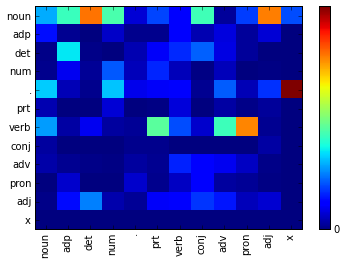

In [91]:
hmm = hmmc.HMM(corpus.word_dict, corpus.tag_dict)
hmm.train_supervised(train_seq)
hmm.print_transition_matrix()

Look at the transition probabilities of the trained model,
and see if they match your intuition about the English language 
(e.g. adjectives tend to come before nouns). Each column is the previous state and row is the current state. Note the high probability of having Noun after Determinant or Adjective, or of having Verb after Nouns or Pronouns, as expected.

## Exercise 2.9

Test the model using both posterior decoding and Viterbi decoding on
both the train and test set, using the methods in class HMM

In [92]:
viterbi_pred_train = hmm.viterbi_decode_corpus(train_seq) 
posterior_pred_train = hmm.posterior_decode_corpus(train_seq)
eval_viterbi_train = hmm.evaluate_corpus(train_seq, viterbi_pred_train)
eval_posterior_train = hmm.evaluate_corpus(train_seq, posterior_pred_train)
print "Train Set Accuracy: Posterior Decode %.3f, Viterbi Decode: %.3f"%(eval_posterior_train,eval_viterbi_train)

Train Set Accuracy: Posterior Decode 0.292, Viterbi Decode: 0.985


In [93]:
viterbi_pred_test = hmm.viterbi_decode_corpus(test_seq) 
posterior_pred_test = hmm.posterior_decode_corpus(test_seq) 
eval_viterbi_test = hmm.evaluate_corpus(test_seq,viterbi_pred_test)
eval_posterior_test = hmm.evaluate_corpus(test_seq,posterior_pred_test) 
print "Test Set Accuracy: Posterior Decode %.3f, Viterbi Decode: %.3f"%(
    eval_posterior_test,eval_viterbi_test)

Test Set Accuracy: Posterior Decode 0.283, Viterbi Decode: 0.509



- What do you observe? 

Remake the previous exercise but now train the HMM using smoothing.
Try different values (0,0.1,0.01,1) and report the results on the train and 
development set. (Use function pick best smoothing).

In [95]:
best_smoothing = hmm.pick_best_smoothing(train_seq, dev_seq, [10,1,0.1,0])

Smoothing 10.000000 --  Train Set Accuracy: Posterior Decode 0.731, Viterbi Decode: 0.691
Smoothing 10.000000 -- Test Set Accuracy: Posterior Decode 0.712, Viterbi Decode: 0.675
Smoothing 1.000000 --  Train Set Accuracy: Posterior Decode 0.887, Viterbi Decode: 0.865
Smoothing 1.000000 -- Test Set Accuracy: Posterior Decode 0.818, Viterbi Decode: 0.792
Smoothing 0.100000 --  Train Set Accuracy: Posterior Decode 0.968, Viterbi Decode: 0.965
Smoothing 0.100000 -- Test Set Accuracy: Posterior Decode 0.851, Viterbi Decode: 0.842
Smoothing 0.000000 --  Train Set Accuracy: Posterior Decode 0.292, Viterbi Decode: 0.985
Smoothing 0.000000 -- Test Set Accuracy: Posterior Decode 0.296, Viterbi Decode: 0.526


In [98]:
hmm.train_supervised(train_seq, smoothing=best_smoothing)
viterbi_pred_test = hmm.viterbi_decode_corpus(test_seq)
posterior_pred_test = hmm.posterior_decode_corpus(test_seq)
eval_viterbi_test = hmm.evaluate_corpus(test_seq, viterbi_pred_test) 
eval_posterior_test = hmm.evaluate_corpus(test_seq, posterior_pred_test)
print "Best Smoothing %f -- Test Set Accuracy: Posterior Decode %.3f, Viterbi Decode: %.3f"%(best_smoothing,eval_posterior_test,eval_viterbi_test)

Best Smoothing 0.100000 -- Test Set Accuracy: Posterior Decode 0.837, Viterbi Decode: 0.827


 Perform some error analysis to understand were the errors are coming from. 

 You can start by visualizing the confusion matrix (true tags vs predicted tags). 

You should get something like what is shown in Figure 2.5.

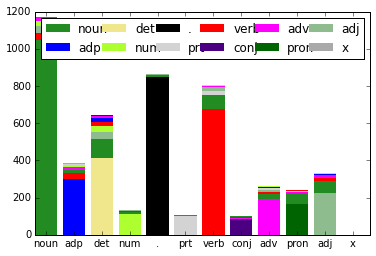

In [101]:
import lxmls.sequences.confusion_matrix as cm
import matplotlib.pyplot as plt
confusion_matrix = cm.build_confusion_matrix(test_seq.seq_list, viterbi_pred_test, len(corpus.tag_dict), hmm.get_num_states()) 
cm.plot_confusion_bar_graph(confusion_matrix, corpus.tag_dict, xrange(hmm.get_num_states()), 'Confusion matrix')
plt.show()

#  Unsupervised Learning of HMMs

> If you have made it so far you are awesome! 

> Don't worry the next couple of exercices do not require to actually code anything.

We next address the problem of unsupervised learning. In this setting, 
we are not given any labeled data.

All we get to see is a set of natural language sentences. 

## Exercise 2.10

Implement the method to update the counts given the state and transition posteriors

```
def update_counts(self, sequence, state_posteriors, transition_posteriors):
```

Look at the code for EM algorithm in file ```sequences/hmm.py``` and check it for yourself.

In [104]:
    def train_EM(self, dataset, smoothing=0, num_epochs=10, evaluate=True):
        self.initialize_random()

        if evaluate:
            acc = self.evaluate_EM(dataset)
            print "Initial accuracy: %f"%(acc)

        for t in xrange(1, num_epochs):
            #E-Step
            total_log_likelihood = 0.0
            self.clear_counts(smoothing)
            for sequence in dataset.seq_list:
                # Compute scores given the observation sequence.
                initial_scores, transition_scores, final_scores, emission_scores = \
                    self.compute_scores(sequence)

                state_posteriors, transition_posteriors, log_likelihood = \
                    self.compute_posteriors(initial_scores,
                                            transition_scores,
                                            final_scores,
                                            emission_scores)
                self.update_counts(sequence, state_posteriors, transition_posteriors)
                total_log_likelihood += log_likelihood

            print "Iter: %i Log Likelihood: %f"%(t, total_log_likelihood)
            #M-Step
            self.compute_parameters()
            if evaluate:
                 ### Evaluate accuracy at this iteration
                acc = self.evaluate_EM(dataset)
                print "Iter: %i Accuracy: %f"%(t,acc)


## Exercise 2.11

Run 20 epochs of the EM algorithm for part of speech induction:


In [105]:
hmm.train_EM(train_seq, 0.1, 20, evaluate=True)
viterbi_pred_test = hmm.viterbi_decode_corpus(test_seq)
posterior_pred_test = hmm.posterior_decode_corpus(test_seq) 
eval_viterbi_test = hmm.evaluate_corpus(test_seq, viterbi_pred_test)
eval_posterior_test = hmm.evaluate_corpus(test_seq, posterior_pred_test)

Initial accuracy: 0.329191
Iter: 1 Log Likelihood: -101889.832960
Iter: 1 Accuracy: 0.357150
Iter: 2 Log Likelihood: -78082.232249
Iter: 2 Accuracy: 0.386211
Iter: 3 Log Likelihood: -77911.084051
Iter: 3 Accuracy: 0.385209
Iter: 4 Log Likelihood: -77505.294694
Iter: 4 Accuracy: 0.390721
Iter: 5 Log Likelihood: -76794.989125
Iter: 5 Accuracy: 0.392324
Iter: 6 Log Likelihood: -75741.573754
Iter: 6 Accuracy: 0.391923
Iter: 7 Log Likelihood: -74358.448480
Iter: 7 Accuracy: 0.389318
Iter: 8 Log Likelihood: -72634.844428
Iter: 8 Accuracy: 0.389117
Iter: 9 Log Likelihood: -70727.562059
Iter: 9 Accuracy: 0.386111
Iter: 10 Log Likelihood: -69059.827265
Iter: 10 Accuracy: 0.385810
Iter: 11 Log Likelihood: -67744.322496
Iter: 11 Accuracy: 0.385610
Iter: 12 Log Likelihood: -66699.140415
Iter: 12 Accuracy: 0.385409
Iter: 13 Log Likelihood: -65985.407048
Iter: 13 Accuracy: 0.385209
Iter: 14 Log Likelihood: -65699.884271
Iter: 14 Accuracy: 0.385209
Iter: 15 Log Likelihood: -65624.890040
Iter: 15 Accu

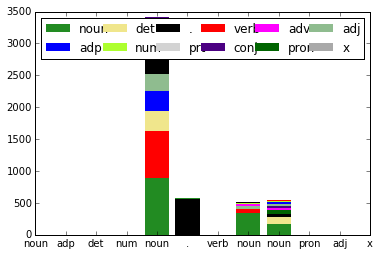

In [106]:
confusion_matrix = cm.build_confusion_matrix(test_seq.seq_list, viterbi_pred_test, len(corpus.tag_dict), hmm.get_num_states())

cm.plot_confusion_bar_graph(confusion_matrix, corpus.tag_dict, xrange(hmm.get_num_states()), 'Confusion matrix')